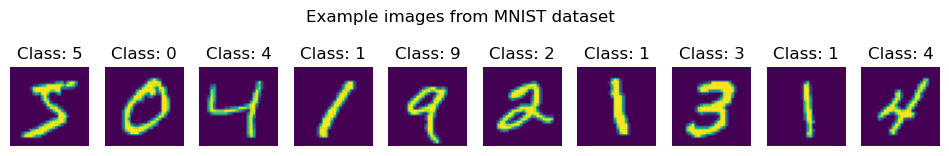

In [102]:
import torch
import numpy as np
from torchvision.transforms import v2, ToPILImage
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.v2.functional as F

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def plot_image_grid(fig, outer_spec, img, mask, title):
    # Creates a grid to plot masked or unmasked images
    
    ax = plt.Subplot(fig, outer_spec)
    ax.set_title(title)
    ax.axis("off")
    fig.add_subplot(ax)
    
    inner = gridspec.GridSpecFromSubplotSpec(7, 7, subplot_spec=outer_spec, wspace=0.1, hspace=0.1)
    for idx in range(49):  # Assuming you have a grid of 7x7 = 49 images
        ax = plt.Subplot(fig, inner[idx])
        if mask[idx] == 0:
            ax.imshow(ToPILImage()(img[idx]))
        ax.axis("off")
        fig.add_subplot(ax)
        
    return

def plot_single_image(fig, outer_spec, image, title):
    # Function to plot a single image
    inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer_spec, wspace=0.1, hspace=0.1)
    ax = plt.Subplot(fig, inner[0])
    ax.imshow(image)
    ax.set_title(title, fontsize=12)
    ax.axis("off")
    fig.add_subplot(ax)
    return


transform = v2.Compose([v2.PILToTensor()])
# Load MNIST dataset
X_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
X_test = datasets.MNIST('../data', train=False, download=True, transform=transform)

# Visualize some samples
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    input, classes = X_train[i]
    plt.imshow(input.squeeze())
    plt.title(f"Class: {classes}")
    plt.axis("off")

plt.suptitle("Example images from MNIST dataset")
plt.show()

## Very basic autoencoder

In [5]:

patch_size = 4
n_patches = 49
mask_ratio = 0.5
masked_img_size = 49- int(49 * mask_ratio)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

def extract_patches(img, patch_size):
    imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
    return imgp

def apply_mask(imgs, mask_ratio):
    batch_size = imgs.shape[0]
    num_patches = imgs.shape[1]
    mask_count = int(num_patches * mask_ratio)
    masks = torch.zeros(batch_size, num_patches)

    for i in range(batch_size):
        mask_idx = torch.randperm(num_patches)[:mask_count]
        masks[i, mask_idx] = 1  # Set the selected indices to 1 (mask)
    
    return masks

# Returns a tensor of size [batch_size, num_patches, patch_size, patch_size]
def collate_fn(batch):
    images, _ = zip(*batch)
    imgs = np.array([np.asarray(image) for image in images]) / 255.0
    imgs = torch.tensor(imgs, dtype=torch.float32)
    imgs_orig = imgs.clone().reshape(imgs.shape[0], -1)
    imgs = torch.cat([extract_patches(img, patch_size) for img in imgs], dim=1)
    imgs = imgs.permute(1, 0, 2, 3)
    return imgs, imgs_orig

batch_size = 256
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn, drop_last=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn, drop_last=True)


## Visualize

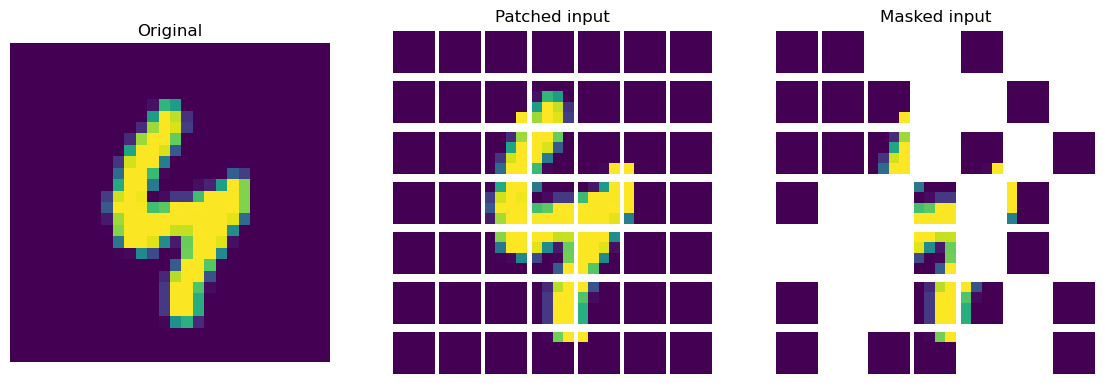

In [103]:
imgs, imgs_orig = next(iter(train_loader))
img, imgs_orig = imgs[0], imgs_orig[0]
masks = apply_mask(imgs, mask_ratio)
mask = masks[0]

# Create a figure for plotting
fig = plt.figure(figsize=(14, 4.5))
outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.3)  # Adjusted for better layout spacing
# Plot grid of masked/unmasked images

# Plot original image
plot_single_image(fig, outer[0], imgs_orig.reshape(28,28), title="Original")

# Plot patchified original image
mask_zero = mask.clone()
mask_zero[mask_zero.eq(1)] = 0
plot_image_grid(fig, outer[1], img, mask_zero, title="Patched input")


plot_image_grid(fig, outer[2], img, mask, title="Masked input")

In [7]:


class Autoencoder(nn.Module):
    def __init__(self, patch_size, masked_img_size):
        super(Autoencoder, self).__init__()
        self.patch_size = patch_size
        self.masked_img_size = masked_img_size
        self.patch_dim = masked_img_size*16*1  # Grayscale image, so 1 channel
        self.embed = 32
        self.embed_dim = masked_img_size*self.embed
        
        # Encoding layer
        self.enc_fc1 = nn.Linear(self.patch_dim, 256)
        self.enc_fc2 = nn.Linear(256, self.embed_dim)
        self.enc_act = nn.ReLU()
        
        self.enc_positions = nn.Parameter(torch.randn(masked_img_size, self.embed))  # +1 for cls_token

        # Decoding layer
        self.dec_fc1 = nn.Linear(49*32, 512)
        self.dec_fc2 = nn.Linear(512, 28*28)
        self.dec_act = nn.Sigmoid()

    def _initialize_weights(self):
        # Xavier initialization for Linear layers
        nn.init.xavier_uniform_(self.enc_fc.weight)
        nn.init.xavier_uniform_(self.dec_fc.weight)

    def encode(self, x):
        batch_s = x.shape[0]
        x = self.enc_fc1(x)
        x = self.enc_act(x)
        x = self.enc_fc2(x)
        x = self.enc_act(x)
        x = x.reshape(batch_s, self.masked_img_size, self.embed)
        # position = self.enc_positions.expand(batch_s, -1, -1)
        # x = x + position
        return x

    def decode(self, x, masks):
        batch_s = x.shape[0]

        # Initialize the token
        tokens = torch.zeros((batch_s, 49, 32))

        # Set the token in the unmasked positions as received from the encoder
        tokens[masks.eq(0)] = x.view(-1, 32)

        # Initialize a masked token
        num_masked = 49 - x.shape[1]
        mask_token = nn.Parameter(torch.zeros(batch_s, num_masked, 32)) # [1, 1, 32]
        torch.nn.init.normal_(mask_token, std=.02)

        # Set the values based on the mask token
        tokens[masks.eq(1)] = mask_token.expand(-1, num_masked, -1).view(-1, 32) # torch.Size([128, 49, 32])

        # Initialize the position
        # decoder_pos_embed = nn.Parameter(torch.zeros(batch_s, 49, 32))
        # tokens = tokens+decoder_pos_embed
                    
        tokens = tokens.view(batch_s, -1)
        # Feed to the decoder
        x = self.dec_fc1(tokens)
        x = self.enc_act(x)
        x = self.dec_fc2(x)
        x = self.dec_act(x)
        return x

    def forward(self, x):
        # Encoding and decoding patches
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded


In [8]:
# Initialize the model
model = Autoencoder(patch_size=patch_size, masked_img_size=masked_img_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.BCELoss()

# Training loop with patch masking
def train(model, train_loader, mask_ratio, patch_size):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        imgs, imgs_orig = batch
        imgs = imgs.to(device)
        imgs_orig = imgs_orig.to(device)

        batch_size, num_patches, h, w = imgs.shape
        imgs = imgs.view(batch_size, num_patches,  h * w)

        # Apply random mask
        masks = apply_mask(imgs, mask_ratio)
        
        img_data = imgs[masks.eq(0)].view(batch_size, masked_img_size * 16)

        # Forward pass with visible patches
        output = model.encode(img_data)
        output = model.decode(output, masks)
        # # Reconstruct and compute the loss with the original full image patches
        loss = loss_fn(output, imgs_orig)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss /= len(train_loader)
    return running_loss

# Training loop
epochs = 15
for epoch in range(epochs):
    train_loss = train(model, train_loader, mask_ratio, patch_size)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

  0%|          | 0/234 [00:00<?, ?it/s]

100%|██████████| 234/234 [00:09<00:00, 23.42it/s]


Epoch 1/15, Loss: 0.2493


100%|██████████| 234/234 [00:09<00:00, 24.37it/s]


Epoch 2/15, Loss: 0.1646


100%|██████████| 234/234 [00:10<00:00, 22.37it/s]


Epoch 3/15, Loss: 0.1412


100%|██████████| 234/234 [00:12<00:00, 19.30it/s]


Epoch 4/15, Loss: 0.1335


100%|██████████| 234/234 [00:12<00:00, 18.21it/s]


Epoch 5/15, Loss: 0.1295


100%|██████████| 234/234 [00:12<00:00, 18.70it/s]


Epoch 6/15, Loss: 0.1272


100%|██████████| 234/234 [00:12<00:00, 19.36it/s]


Epoch 7/15, Loss: 0.1256


100%|██████████| 234/234 [00:15<00:00, 14.99it/s]


Epoch 8/15, Loss: 0.1244


100%|██████████| 234/234 [00:15<00:00, 14.82it/s]


Epoch 9/15, Loss: 0.1236


100%|██████████| 234/234 [00:14<00:00, 16.33it/s]


Epoch 10/15, Loss: 0.1225


100%|██████████| 234/234 [00:17<00:00, 13.30it/s]


Epoch 11/15, Loss: 0.1219


100%|██████████| 234/234 [00:15<00:00, 14.77it/s]


Epoch 12/15, Loss: 0.1215


100%|██████████| 234/234 [00:14<00:00, 16.60it/s]


Epoch 13/15, Loss: 0.1209


100%|██████████| 234/234 [00:16<00:00, 14.53it/s]


Epoch 14/15, Loss: 0.1204


100%|██████████| 234/234 [00:17<00:00, 13.20it/s]

Epoch 15/15, Loss: 0.1198


## Visualize the predictions

Initialize some helper functions

# Select a random sample, apply random masking and visualize the predictions

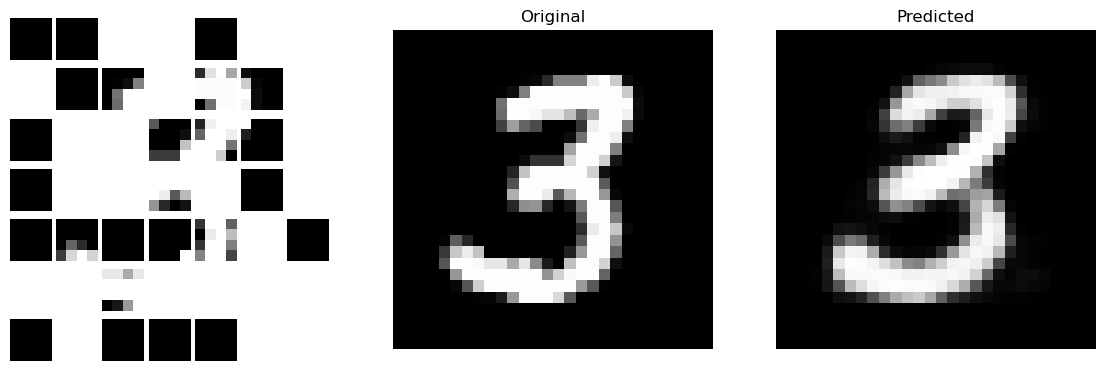

In [50]:

# Select a random sample
samples, orig = next(iter(test_loader))
masks = apply_mask(samples, mask_ratio)

img = samples[0]
orig_img = orig[0].reshape(28,28)
mask = masks[0]

# Use the encode and decode functions
masked = img.clone()[mask.eq(0)]
masked = masked.view(-1, masked_img_size*16)

encoded_output = model.encode(masked)
predicted_img = model.decode(encoded_output, mask.unsqueeze(0)).detach().numpy().reshape(28, 28)

# Create a figure for plotting
fig = plt.figure(figsize=(14, 4.5))
outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.3)  # Adjusted for better layout spacing

# Plot grid of masked/unmasked images
plot_image_grid(fig, outer[0], img, mask, title="Masked Input")

# Plot original image
plot_single_image(fig, outer[1], orig_img, title="Original")

# Plot predicted image
plot_single_image(fig, outer[2], predicted_img, title="Predicted")

# Show the figure
plt.show()